
# Peer-graded Assignment: Test a Multiple Regression Model

In [2]:

!pip install numpy --upgrade --quiet

In [3]:

!pip install pandas --upgrade --quiet

In [4]:

!pip install matplotlib --upgrade --quiet

In [5]:

!pip install statsmodels --upgrade --quiet

In [6]:

!pip install seaborn --upgrade --quiet

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [8]:

print(pd.describe_option('display.float_format'))

display.float_format : callable
    The callable should accept a floating point number and return
    a string with the desired format of the number. This is used
    in some places like SeriesFormatter.
    See formats.format.EngFormatter for an example.
    [default: None] [currently: None]


None


In [9]:

# Bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%.2f'%x)

In [10]:

%run ../../../load_magic/storage.py
%who

data_folder = ../../data/
saves_folder = ../../saves/
attempt_to_pickle	 current_directory	 data_folder	 encoding	 folder_list	 load_csv	 load_dataframes	 load_object	 np	 
os	 pd	 pickle	 plt	 save_dataframes	 saves_folder	 sb	 sm	 smf	 
store_objects	 sys	 


In [11]:

gapminder_df = load_object('gapminder_df')
gapminder_df.columns

Index(['country_name', 'income_per_person', 'alcohol_consumption',
       'armed_forces_rate', 'breast_cancer_per100th', 'co2_emissions',
       'female_employ_rate', 'hiv_rate', 'internet_use_rate',
       'life_expectancy', 'oil_per_person', 'polity_score',
       'electricity_per_person', 'suicide_per100th', 'employ_rate',
       'urban_rate'],
      dtype='object')

In [12]:

%run ../../../load_magic/dataframes.py
%who

attempt_to_pickle	 current_directory	 data_folder	 encoding	 example_iterrows	 folder_list	 gapminder_df	 get_column_descriptions	 load_csv	 
load_dataframes	 load_object	 math	 np	 os	 pd	 pickle	 plt	 save_dataframes	 
saves_folder	 sb	 sm	 smf	 store_objects	 sys	 



<p>This week's assignment is to test a multiple regression model.</p>
<p><strong>Data preparation for this assignment:</strong></p>
<p>1) If your response variable is categorical, you will need to identify a quantitative variable in the data set that you can use as a response variable for this assignment. Variables with response scales with 4-5 values that represent a change in magnitude (eg, "strongly disagree to strongly agree", "never to often") can be considered quantitative for the assignment.</p>

In [67]:

get_column_descriptions(gapminder_df, column_list=None).sort_values('count_uniques', ascending=False)

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates
15,country_name,object,0,289,0,False
4,co2_emissions,float64,77,213,0,True
14,urban_rate,float64,81,200,0,True
8,life_expectancy,float64,92,196,0,True
7,internet_use_rate,float64,97,193,0,True
0,income_per_person,float64,98,192,0,True
12,suicide_per100th,float64,98,192,0,True
1,alcohol_consumption,float64,102,181,0,True
2,armed_forces_rate,float64,125,165,1,True
5,female_employ_rate,float64,111,154,0,True


<p><strong>The assignment:</strong></p>
<p>Write a blog entry that summarize in a few sentences<ol><li>what you found in your multiple regression analysis. Discuss the results for the associations between <strong>all</strong> of your explanatory variables and your response variable. Make sure to include statistical results (Beta coefficients and p-values) in your summary.</li><ol>


## Hypothesis: CO<sub>2</sub> emissions is significantly and positively associated with oil per person, after adjusting for the potential confounding factor of urban rate

In [95]:

formal_name_dict = load_object('formal_name_dict')
informal_name_dict = load_object('informal_name_dict')
class Statements(object):

    def __init__(self, df, **kwargs):
        prop_defaults = {
            'qr_column_name': 'co2_emissions',
            'qpe_column_name': 'oil_per_person',
            'qse_column_name': 'urban_rate',
            
            'qr_formal_name': None,
            'qpe_formal_name': None,
            'qse_formal_name': None,
            
            'qr_informal_name': None,
            'qpe_informal_name': None,
            'qse_informal_name': None,
        }

        for (prop, default) in prop_defaults.items():
            setattr(self, prop, kwargs.get(prop, default))
        
        # Initialize formal/informal names

        if self.qr_formal_name is None:
            self.qr_formal_name = formal_name_dict[self.qr_column_name]
        if self.qr_informal_name is None:
            self.qr_informal_name = informal_name_dict[self.qr_column_name]

        if self.qpe_formal_name is None:
            self.qpe_formal_name = formal_name_dict[self.qpe_column_name]
        if self.qpe_informal_name is None:
            self.qpe_informal_name = informal_name_dict[self.qpe_column_name]

        if self.qse_formal_name is None:
            self.qse_formal_name = formal_name_dict[self.qse_column_name]
        if self.qse_informal_name is None:
            self.qse_informal_name = informal_name_dict[self.qse_column_name]

        self.subset_columns = ['country_name', self.qr_column_name, self.qpe_column_name,
                               self.qse_column_name]
        self.df = df.dropna(how='any', subset=self.subset_columns).copy()
        self.row_count = self.df.shape[0]
        
        # Center quantitative IVs for regression analysis
        self.qpec_column_name = self.qpe_column_name + '_c'
        self.qsec_column_name = self.qse_column_name + '_c'
        self.df[self.qpec_column_name] = (self.df[self.qpe_column_name] -
                                          self.df[self.qpe_column_name].mean())
        self.df[self.qsec_column_name] = (self.df[self.qse_column_name] -
                                          self.df[self.qse_column_name].mean())

        # Use ols function for calculating the F-statistic and associated p value
        self.lra_formula = self.qr_column_name + ' ~ ' + self.qpec_column_name
        self.lra_fitted = smf.ols(formula=self.lra_formula, data=self.df).fit()
        self.lra_coef_series = self.lra_fitted.params
        self.lra_qpec_beta_statement = str('%.2e' % self.lra_coef_series[self.qpec_column_name])
        self.lra_df_model_statement = str('%d' % self.lra_fitted.df_model)
        self.lra_df_resid_statement = str('%d' % self.lra_fitted.df_resid)
        self.lra_fvalue_statement = str('%.2f' % self.lra_fitted.fvalue)
        self.lra_f_pvalue = self.lra_fitted.f_pvalue
        if self.lra_f_pvalue < 0.0001:
            self.lra_f_pvalue_statement = '&lt;0.0001'
        else:
            self.lra_f_pvalue_statement = '=' + str('%.4f' % self.lra_f_pvalue)

        # Figure out the adverbs
        if self.lra_f_pvalue <= 0.05:
            self.lra_adverb_significant = 'a significantly'
        else:
            self.lra_adverb_significant = 'an insignificantly'
        
        # Quadratic (polynomial) regression analysis
        self.sop_formula = (self.qr_column_name + ' ~ ' + self.qpec_column_name +
                            ' + I(' + self.qpec_column_name + '**2)')
        self.sop_fitted = smf.ols(formula=self.sop_formula, data=self.df).fit()
        self.sop_df_model_statement = str('%d' % self.sop_fitted.df_model)
        self.sop_df_resid_statement = str('%d' % self.sop_fitted.df_resid)
        self.sop_fvalue_statement = str('%.2f' % self.sop_fitted.fvalue)
        self.sop_f_pvalue = self.sop_fitted.f_pvalue
        if self.sop_f_pvalue < 0.0001:
            self.sop_f_pvalue_statement = '&lt;0.0001'
        else:
            self.sop_f_pvalue_statement = '=' + str('%.4f' % self.sop_f_pvalue)

        # Figure out the adverbs
        if self.sop_f_pvalue <= 0.05:
            self.sop_adverb_significant = 'a significantly'
        else:
            self.sop_adverb_significant = 'an insignificantly'
        
        # Adding secondary explanatory variable
        self.lras_formula = (self.qr_column_name + ' ~ ' + self.qpec_column_name +
                             ' + I(' + self.qpec_column_name + '**2) + ' + self.qsec_column_name)
        self.lras_fitted = smf.ols(formula=self.lras_formula, data=self.df).fit()
        self.lras_df_model_statement = str('%d' % self.lras_fitted.df_model)
        self.lras_df_resid_statement = str('%d' % self.lras_fitted.df_resid)
        self.lras_fvalue_statement = str('%.2f' % self.lras_fitted.fvalue)
        self.lras_f_pvalue = self.lras_fitted.f_pvalue
        if self.lras_f_pvalue < 0.0001:
            self.lras_f_pvalue_statement = '&lt;0.0001'
        else:
            self.lras_f_pvalue_statement = '=' + str('%.4f' % self.lras_f_pvalue)

        # Figure out the adverbs
        if self.lras_f_pvalue <= 0.05:
            self.lras_adverb_significant = 'a significantly'
        else:
            self.lras_adverb_significant = 'an insignificantly'

In [97]:

# CO2 emissions associated with oil per person,
# with the confounding factor of urban rate
response_variable = 'co2_emissions'
primary_explanatory_variable = 'oil_per_person'
secondary_explanatory_variable = 'urban_rate'
sts = Statements(df=gapminder_df, qr_column_name=response_variable,
                 qpe_column_name=primary_explanatory_variable,
                 qse_column_name=secondary_explanatory_variable)

In [100]:

print(sts.lra_df_model_statement)
print(sts.lra_df_resid_statement)
print(sts.lra_fvalue_statement)
print(sts.lra_f_pvalue)

1
60
0.12
0.7251613496626517


In [98]:

from IPython.display import HTML, Image

def model_interpretation(sts, sample_name='the population', verbose=False):
        
    # Analysis of Variance (ANOVA)
    sts.test_type_html = ('<h3>Model Interpretation for ANOVA, Testing a Multiple Regression Model:</h3>' +
                          '<p>After adjusting for potential confounding factors (' +
                          sts.qse_informal_name + '), ' +
                          sts.qpe_informal_name + ' (Beta=1.34, p' +
                          sts.f_pvalue_statement + ') was ' +
                          sts.adverb_significant + ' and positively associated with ' +
                          sts.qr_informal_name + '. Age was also significantly associated with nicotine dependence symptoms, such that older participants reported a greater number of nicotine dependence symptoms (Beta= 0.76, p=.025).' +
                          sts.qr_formal_name + ' (the quantitative response variable) and ' +
                          sts.qpe_formal_name + ' (the primary quantitative explanatory variable), ' +
                          'an Analysis of Variance (ANOVA) ')
    sts.test_type_html += ('revealed that among ' +
                           sample_name + ', those countries with a higher ' +
                           sts.ce_informal_name + ' reported ' +
                           sts.adverb_significant + ' ' +
                           sts.adverb_higher + ' ' +
                           sts.qr_informal_name + ' (Mean=' +
                           sts.high_mean_statement + ', s.d. &plusmn;' +
                           sts.high_sd_statement + ') compared to those with a lower ' +
                           sts.ce_informal_name + ' (Mean=' +
                           sts.low_mean_statement + ', s.d. &plusmn;' +
                           sts.low_sd_statement + '), F(' +
                           sts.df_model_statement + ', ' +
                           sts.df_resid_statement + ')=' +
                           sts.fvalue_statement + ', p.</p>')
    
    if verbose:
        
        # Analysis of Variance (ANOVA)
        sts.fitted.summary()
        #plot_Image = add_joint_plot(sts)
        #plot_Image = add_facet_grid(sts)

        # From http://www.1x1px.me/
        file_path = '../../data/png/FFFFFF-0.0.png'
        plot_Image = Image(data=file_path)
            
    else:
        
        # From http://www.1x1px.me/
        file_path = '../../data/png/FFFFFF-0.0.png'
        plot_Image = Image(data=file_path)
    
    return HTML(sts.test_type_html + sts.verbose_html), plot_Image

In [ ]:

# A response variable corresponds to a dependent variable while
# an explanatory variable corresponds to an independent variable
def moderator_conclusion(both_sts, low_sts, high_sts):
    summary_html = ('<h3>Summary</h3><p>The effect of the moderating (' +
                    both_sts.md_informal_name + ') variable is characterized ' +
                    'statistically as an interaction; that is, a categorical (in this case low or high) ' +
                    'variable that affects the strength of the relation between the dependent (')
        
    # Analysis of Variance (ANOVA)
    summary_html += (both_sts.qr_informal_name + ') variable and the independent (' +
                     both_sts.ce_informal_name + ') variable. In our study, the strength of the association ' +
                     '(Chi Square test of Independence) between ' +
                     both_sts.qr_informal_name + ' and ' +
                     both_sts.ce_informal_name + ', when considering only the high ' +
                     high_sts.moderator_statement + ' of ' +
                     high_sts.md_informal_name + ', ' +
                     verb_high_increased + ' from F=' +
                     both_sts.fvalue_statement + ' to F=' +
                     high_sts.fvalue_statement + '. Similarly, when considering only the low ' +
                     low_sts.moderator_statement + ' of ' +
                     low_sts.md_informal_name + ', the strength of the association ' +
                     verb_low_increased + ' from F=' +
                     both_sts.fvalue_statement + ' to F=' +
                     low_sts.fvalue_statement + '.')
    
    return HTML(summary_html)

In [99]:

import IPython.display

def anova_with_confounding(sts, source_name='GapMinder.org', verbose=False):
    
    # Interpret both groups
    sample_name = 'the sample of ' + str(both_sts.row_count) + ' countries from ' + source_name
    model_interpretation_HTML, plot_Image = model_interpretation(both_sts, sample_name, verbose)
    display(model_interpretation_HTML)
    display(plot_Image)
    
    display(moderator_conclusion(both_sts, low_sts, high_sts))

####################################################################################
# POLYNOMIAL REGRESSION
####################################################################################

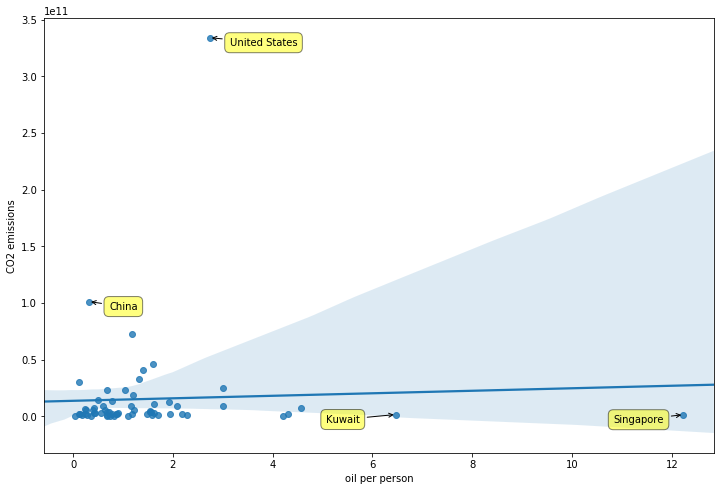

In [94]:

# First order (linear) scatterplot
fig1_fig = plt.figure(figsize=(12,8))
scat1_axes_subplot = sns.regplot(x=primary_explanatory_variable, y=response_variable, scatter=True, data=sub1_df)
xlabel_text = plt.xlabel(informal_name_dict[primary_explanatory_variable])
ylabel_text = plt.ylabel(informal_name_dict[response_variable])
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for label, x, y in zip(sub1_df['country_name'], sub1_df[primary_explanatory_variable],
                            sub1_df[response_variable]):
    if (y > 1.0E11):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, -10), **kwargs)
    if (x > 6):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-70, -10), **kwargs)

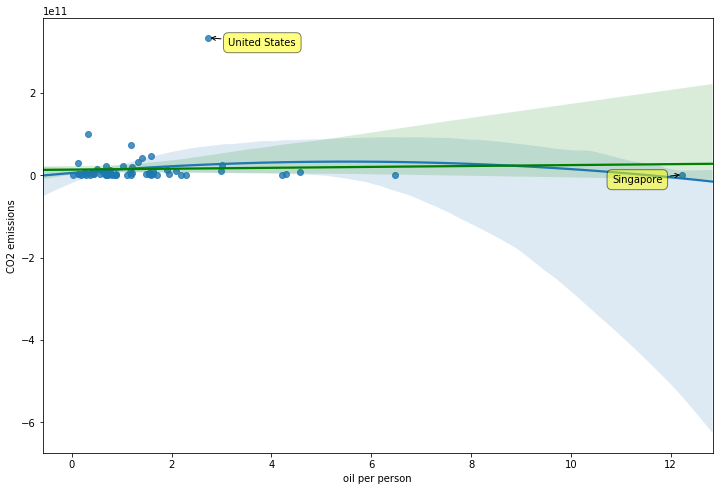

In [91]:

# Fit second order polynomial
fig2_fig = plt.figure(figsize=(12,8))
scat2_axes_subplot = sns.regplot(x=primary_explanatory_variable, y=response_variable, scatter=True, order=2,
                                 data=sub1_df)

# Run the 2 scatterplots together to get both linear and second order fit lines
scat3_axes_subplot = sns.regplot(x=primary_explanatory_variable, y=response_variable, scatter=True, order=1,
                                 data=sub1_df, ax=fig2_fig.get_axes()[0],
                                 scatter_kws=dict(s=0, edgecolors='w'), color='g')

xlabel_text = plt.xlabel(informal_name_dict[primary_explanatory_variable])
ylabel_text = plt.ylabel(informal_name_dict[response_variable])
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
for label, x, y in zip(sub1_df['country_name'], sub1_df[primary_explanatory_variable],
                            sub1_df[response_variable]):
    if (y > 3.0E11):
        annotation = plt.annotate(label, xy=(x, y), xytext=(20, -10), **kwargs)
    if (x > 12):
        annotation = plt.annotate(label, xy=(x, y), xytext=(-70, -10), **kwargs)

In [92]:

# Center quantitative IVs for regression analysis
pe_variable_centered = 'oil_per_person_c'
se_variable_centered = 'urban_rate_c'
sub1_df[pe_variable_centered] = (sub1_df[primary_explanatory_variable] - sub1_df[primary_explanatory_variable].mean())
sub1_df[se_variable_centered] = (sub1_df[secondary_explanatory_variable] - sub1_df[secondary_explanatory_variable].mean())
column_list = [pe_variable_centered, se_variable_centered]
sub1_df[column_list].describe()

,oil_per_person_c,urban_rate_c
count,62.00,62.00
mean,-0.00,0.00
std,1.84,17.28
min,-1.44,-42.42
25%,-0.96,-8.48
50%,-0.51,1.17
75%,0.14,12.08
max,10.75,30.44


In [102]:

# Linear regression analysis
reg1_fitted = smf.ols(response_variable + ' ~ ' + pe_variable_centered, data=sub1_df).fit()
print(reg1_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:          co2_emissions   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.1248
Date:                Sun, 18 Mar 2018   Prob (F-statistic):              0.725
Time:                        17:44:16   Log-Likelihood:                -1607.8
No. Observations:                  62   AIC:                             3220.
Df Residuals:                      60   BIC:                             3224.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.545e+10   5.72e+09  

In [104]:

dir(reg1_fitted)

Pretty printing has been turned OFF


['HC0_se', 'HC1_se', 'HC2_se', 'HC3_se', '_HCCM', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_cache', '_data_attr', '_get_robustcov_results', '_is_nested', '_wexog_singular_values', 'aic', 'bic', 'bse', 'centered_tss', 'compare_f_test', 'compare_lm_test', 'compare_lr_test', 'condition_number', 'conf_int', 'conf_int_el', 'cov_HC0', 'cov_HC1', 'cov_HC2', 'cov_HC3', 'cov_kwds', 'cov_params', 'cov_type', 'df_model', 'df_resid', 'diagn', 'eigenvals', 'el_test', 'ess', 'f_pvalue', 'f_test', 'fittedvalues', 'fvalue', 'get_influence', 'get_prediction', 'get_robustcov_results', 'initialize', 'k_constant', 'llf', 'load', 'model', 'mse_model', 'mse_resid', 'mse_total', 'nobs', 'normalized_cov_params'

In [112]:

coef_series = reg1_fitted.params
coef_series

Intercept          15447365467.75
oil_per_person_c    1107436589.20
dtype: float64

<ol start=2><li>Report whether your results supported your hypothesis for the association between your primary explanatory variable and the response variable.</li></ol>

In [ ]:

from IPython.display import HTML


HTML('Before adjusting for potential confounding factors (' +
     formal_name_dict[secondary_explanatory_variable] +
     '), major depression (Beta=1.34, p=.0001) was significantly and positively associated with number of nicotine dependence symptoms.')


<ol start=3><li>Discuss whether there was evidence of confounding for the association between your primary explanatory and response variable (Hint: adding additional explanatory variables to your model one at a time will make it easier to identify which of the variables are confounding variables); and</li></ol>


<ol start=4><li>generate the following regression diagnostic plots:
    <ol type='a'><li>q-q plot</li></ol>
    <ol type='a' start=2><li>standardized residuals for all observations</li></ol>
    <ol type='a' start=3><li>leverage plot</li></ol>
    <ol type='a' start=4><li>Write a few sentences describing what these plots tell you about your regression model in terms of the distribution of the residuals, model fit, influential observations, and outliers.</li></ol></li></ol>
<p><strong>What to Submit: Submit the URL for your blog entry. The blog entry should include 1) the summary of your results that addresses parts 1-4 of the assignment, 2) the output from your multiple regression model, and 3) the regression diagnostic plots.</strong></p>


<p>
    Your assessment will be based on the evidence you
    provide that you have completed all of the steps.
    When relevant, gradients in the scoring will be
    available to reward clarity (for example, you will get
    one point for submitting an inaccurate or incomplete description of your results, but two points if the description is
    accurate and complete). In all cases, consider that
    the peer assessing your work is likely not an expert
    in the field you are analyzing. You will be assessed
    equally on all parts of the assignment, and whether you post your output in your blog entry.
</p>


<p>After adjusting for potential confounding factors (list them), major depression (Beta=1.34, p=.0001) was significantly and positively associated with number of nicotine dependence symptoms. Age was also significantly associated with nicotine dependence symptoms, such that older participants reported a greater number of nicotine dependence symptoms (Beta= 0.76, p=.025).</p>

In [33]:

# Quadratic (polynomial) regression analysis

# Run following line of code if you get PatsyError 'ImaginaryUnit' object is not callable
#del I
reg2_fitted = smf.ols(response_variable + ' ~ ' + pe_variable_centered + ' + I(' + pe_variable_centered + '**2)',
                      data=sub1_df).fit()
print(reg2_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:     female_employ_rate   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     15.60
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           6.30e-07
Time:                        11:27:39   Log-Likelihood:                -672.19
No. Observations:                 167   AIC:                             1350.
Df Residuals:                     164   BIC:                             1360.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              43.8428    


####################################################################################
# EVALUATING MODEL FIT
####################################################################################

In [35]:

# Adding secondary explanatory variable
nancy_str = response_variable + ' ~ ' + pe_variable_centered + ' + I(' + pe_variable_centered + '**2) + ' + se_variable_centered
reg3_fitted = smf.ols(nancy_str, data=sub1_df).fit()
print(reg3_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:     female_employ_rate   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     11.92
Date:                Sat, 17 Mar 2018   Prob (F-statistic):           4.25e-07
Time:                        11:32:00   Log-Likelihood:                -670.17
No. Observations:                 167   AIC:                             1348.
Df Residuals:                     163   BIC:                             1361.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              43.9886    

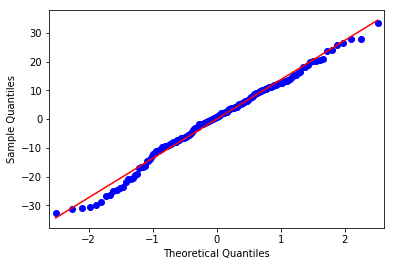

In [36]:

# Q-Q plot for normality
fig4_fig = sm.qqplot(reg3_fitted.resid, line='r')

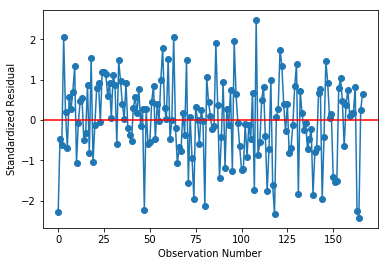

In [45]:

# Simple plot of residuals
stdres_df = pd.DataFrame(reg3_fitted.resid_pearson)
line2d_list = plt.plot(stdres_df, 'o', ls=None)
stdres_line2d = plt.axhline(y=0, color='r')
ylabel_text = plt.ylabel('Standardized Residual')
xlabel_text = plt.xlabel('Observation Number')

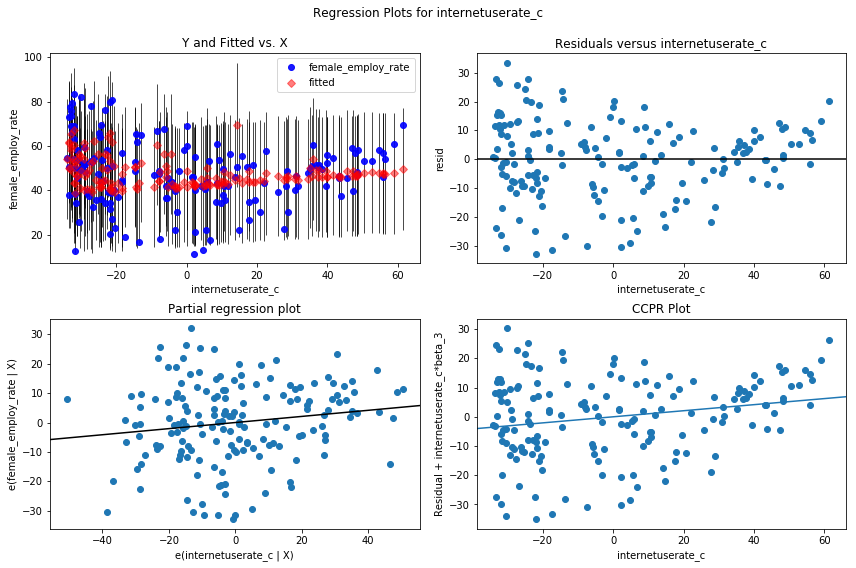

In [48]:

# Additional regression diagnostic plots
fig2_fig = plt.figure(figsize=(12,8))
fig2_fig = sm.graphics.plot_regress_exog(reg3_fitted,  se_variable_centered, fig=fig2_fig)

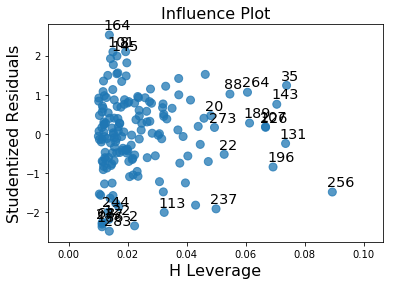

In [66]:

# Leverage plot
fig3_fig = sm.graphics.influence_plot(reg3_fitted, size=8)

In [65]:

reg3_influence = reg3_fitted.get_influence()
reg3_influence_df = reg3_influence.summary_frame()
reg3_influence_df.sample(5).T

,149,116,14,265,120
dfb_Intercept,-0.07,-0.00,0.00,0.04,-0.00
dfb_urbanrate_c,0.04,0.00,0.03,0.01,0.00
dfb_I(urbanrate_c ** 2),-0.00,0.00,0.04,-0.03,0.00
dfb_internetuserate_c,0.06,0.00,0.03,0.00,-0.00
cooks_d,0.01,0.00,0.00,0.00,0.00
dffits,-0.15,0.00,0.10,0.05,-0.01
dffits_internal,-0.15,0.00,0.10,0.05,-0.01
hat_diag,0.01,0.03,0.03,0.01,0.03
standard_resid,-1.25,0.01,0.58,0.48,-0.03
student_resid,-1.25,0.01,0.58,0.47,-0.03
